## AMM Project Decline Curve Simulator v1.1, 3/4/21

### Introduction

This program calculates the expected decline curve for a mine given its coal basin and initial emissions rate upon closure, as well as an estimate for how much AMM a project would capture given project length and the number of years between mine closure and project start. Press shift + return twice to begin!

### Updates

— Comparison with constant percentage drop. (3/4/21)

— Added ARB decline parameters as an option, and clarified wording on final project analyses. (3/2/21)

### Possible improvements

— Sealed, flooded, & partially flooded functionality.

— Quantify/include uncertainty.

— Allow choice of low/mid/high scenario parameters, and for comparison between scenarios for the same inputs.

— Include map of each coal basin on 'info' page.

— Option to save visualizations to .pdf or table to .csv. 

— Option to convert all graphs/tables after running program.

— A way to model CMM transitioning to AMM?

— A portfolio feature.


Hello! This is an Abandoned Mine Methane project simulator. You can use 
it to estimate AMM capture potential at a mine in any U.S. coal basin. Hit return to get started.

What coal basin is the mine in?
    Input 'info' to see options, or hit return for default ARB parameters. 
Default = ARB.
What units would you like to use?
    Input either 'mcfd' or 'MTCO2e/yr'. 
    Or, if you would like results as a fraction of initial emissions rate, input 'frac'. frac
How many years after closure is AMM capture beginning? 5
Finally, for how many years will AMM be captured? 10
Great! Here's your simulated AMM project: 


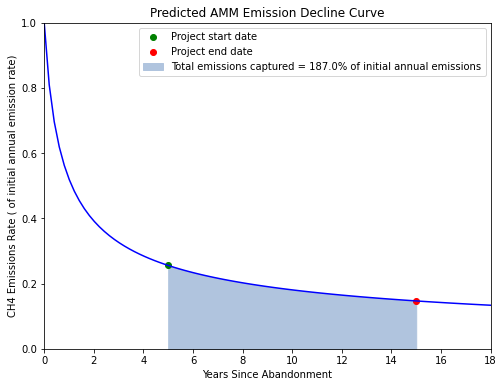

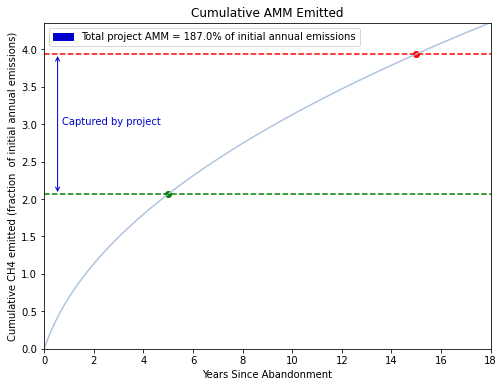

If your project had been one year longer (but started at the same time), 
    you would have captured an additional 14.0% of initial annual emissions.
If your project had started one year earlier (but been the same duration),
    you would have captured an additional 12.0% of initial annual emissions.


Project Length (years),5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
Project TSA (years),,,,,,,,,,,
0.0,206.54%,230.95%,253.41%,274.32%,293.95%,312.5%,330.13%,346.96%,363.08%,378.58%,393.51%
1.0,162.19%,184.65%,205.56%,225.19%,243.74%,261.37%,278.2%,294.32%,309.82%,324.75%,339.19%
2.0,139.87%,160.78%,180.41%,198.96%,216.59%,233.42%,249.54%,265.04%,279.97%,294.41%,308.38%
3.0,125.15%,144.77%,163.32%,180.95%,197.78%,213.9%,229.4%,244.34%,258.77%,272.74%,286.29%
4.0,114.35%,132.9%,150.53%,167.36%,183.48%,198.98%,213.92%,228.35%,242.32%,255.87%,269.04%
5.0,105.96%,123.59%,140.42%,156.54%,172.04%,186.97%,201.41%,215.38%,228.93%,242.1%,254.91%
6.0,99.18%,116.01%,132.13%,147.63%,162.56%,177.0%,190.97%,204.52%,217.69%,230.5%,242.99%
7.0,93.54%,109.67%,125.16%,140.1%,154.53%,168.5%,182.06%,195.23%,208.04%,220.52%,232.7%
8.0,88.76%,104.25%,119.19%,133.62%,147.59%,161.15%,174.32%,187.13%,199.62%,211.8%,223.69%


For more analysis options, press shift + return again!


In [4]:
## Import standard libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.patches as mpatches

## Define some constants for U.S. mines (from EPA, 2007).

b_dict = {"northern appalachian":{"low":2.023397, "mid":2.292595, "high":1.536968}, 
     "illinois":{"low":1.991397, "mid":2.314585, "high":1.656675},
     "central appalachian":{"low":1.960734, "mid":2.329011, "high":1.772918},
     "black warrior":{"low":1.947186, "mid":2.299685, "high":2.030229},
     "western states":{"low":1.000000, "mid":2.342465, "high":1.796142},
         "arb":{"mid":1.886581}}
D_dict = {"northern appalachian":{"low":0.005831, "mid":0.003564, "high":0.001473},
       "illinois":{"low":0.005283, "mid":0.003564, "high":0.001611},
       "central appalachian":{"low":0.004790, "mid":0.003735, "high":0.001765},
       "black warrior":{"low":0.004734, "mid":0.003601, "high":0.002169},
       "western states":{"low":0.004734, "mid":0.003803, "high":0.001799},
         "arb":{"mid":0.003519}}

## Defining all necessary functions for user inputs.

def ask1():
    basin = input("""What coal basin is the mine in?
    Input 'info' to see options, or hit return for default ARB parameters. """)
    if basin.lower() == "info":
        print("""
        'Northern Appalachian': Maryland, Ohio, Pennsylvania, and Northern West Virginia 
        'Illinois': Illinois, Indiana, and Western Kentucky
        'Central Appalachian': Eastern Kentucky, Virginia, Southern West Virginia, and Tennessee
        'Black Warrior': Alabama and Mississippi
        'Western States': Colorado, Utah, and Wyoming
                 """)
        basins = ["Northern Appalachian", "Illinois", "Central Appalachian", "Black Warrior", "Western States"
                 , "ARB"]
        def q(t):
            q = q_i * ((1+b*365*D_i*t) ** (-1/b))
            return q
        for x in basins:
            b= b_dict[x.lower()]["mid"]
            D_i=D_dict[x.lower()]["mid"]
            q_i = 1
            years = np.linspace(0, 20, num=20*50)
            plt.plot(years, q(years),label='2007 %s' %x)
        plt.xlabel('Years since abandonment')
        plt.ylabel('Fraction of initial emission rate')
        plt.legend()
        plt.title("""Comparison of mid-scenario decline curve parameters""")
        plt.show()
        return ask1()
    elif basin.lower() == "illinois":
        parameters = (b_dict["illinois"], D_dict["illinois"])
        return parameters
    elif basin.lower() == "central appalachian":
        parameters = (b_dict["central appalachian"], D_dict["central appalachian"])
        return parameters
    elif basin.lower() == "black warrior":
        parameters = (b_dict["black warrior"], D_dict["black warrior"])
        return parameters
    elif basin.lower() == "western states":
        parameters = (b_dict["western states"], D_dict["western states"])
        return parameters
    elif basin.lower() == "":
        print("Default = ARB.")
        parameters = (b_dict["arb"], D_dict["arb"])
        return parameters
    elif basin.lower() == "northern appalachian":
        parameters = (b_dict["northern appalachian"], D_dict["northern appalachian"])
        return parameters
    else:
        print("Not a valid input.")
        return ask1()

def ask2():
    units = input("""What units would you like to use?
    Input either 'mcfd' or 'MTCO2e/yr'. 
    Or, if you would like results as a fraction of initial emissions rate, input 'frac'. """)
    if units.lower() == 'mcfd':
        units = 'mcfd'
        tot_units ='mcf'
        return (units, tot_units)
    if units.lower() == 'mtco2e/yr':
        units = 'MTCO2e/yr'
        tot_units='MTCO2e'
        return (units, tot_units)
    if units.lower() == '':
        units = 'mcfd'        
        tot_units ='mcf'
        return (units, tot_units)
    if units.lower() == 'frac':
        units = ' of initial annual emission rate'
        tot_units = ' of initial annual emissions'
        return (units, tot_units)
    else:
        print("Not a valid input.")
        return ask2()

def ask3():
    closure_rate = input("""How many %s was the mine emitting at closure? """ % units)
    try:
        if float(closure_rate) >= 0:
            closure_rate = float(closure_rate)
            return closure_rate
        else:
            print("Not a valid input.")
            return ask3()
    except ValueError:
        print("Not a valid input.")
        return ask3()

def ask4():
    tsa = input("How many years after closure is AMM capture beginning? ")
    try:
        if tsa == '':
            tsa = 0
            print("Default: 0 years")
            return tsa
        elif float(tsa) >= 0:
            tsa = float(tsa)
            return tsa
        else:
            print("Not a valid input.")
            return ask4()
    except ValueError:
        print("Not a valid input.")
        return ask4()
    
def ask5():
    project_length = input("Finally, for how many years will AMM be captured? ")
    try:
        if project_length == '':
            project_length = 10
            print("Default: 10 years")
            return project_length
        elif float(project_length) >= 0:
            project_length = float(project_length)
            return project_length
        else:
            print("Not a valid input.")
            return ask5()
    except ValueError:
        print("Not a valid input.")
        return ask5()
    
## Defining decline curve functions using basin-specific parameters.
def q_low(t):
    q_low = q_i * ((1+b["low"]*365*D_i["low"]*t) ** (-1/b["low"]))
    return q_low
def q_mid(t):
    q_mid = q_i * ((1+b["mid"]*365*D_i["mid"]*t) ** (-1/b["mid"]))
    return q_mid
def q_high(t): 
    q_high = q_i * ((1+b["high"]*365*D_i["high"]*t) ** (-1/b["high"]))
    return q_high
unit_scale = {'mcfd':365, 'mtco2e/yr':1, ' of initial annual emission rate':1}
def q_mid_scaled(t): 
    q_mid_scaled = q_mid(t) * unit_scale[units.lower()]
    return q_mid_scaled

def ask0():
    ready = input("""Hello! This is an Abandoned Mine Methane project simulator. You can use 
it to estimate AMM capture potential at a mine in any U.S. coal basin. Hit return to get started.
""")
    return ready

## Receiving all inputs from user.
ready = ask0()
parameters = ask1()
b=parameters[0]
D_i=parameters[1]
units_tuple = ask2()
units=units_tuple[0]
tot_units=units_tuple[1]
if units == ' of initial annual emission rate':
    q_i = 1
else:
    q_i = ask3()
tsa = ask4()
pl = ask5()
print("""Great! Here's your simulated AMM project: """)

## Running all graphical visualizations.

## Standard decline curve.

years = tsa + pl + 3
time = np.linspace(0, years, num=int(years)*5)
project_interval = np.linspace(tsa, tsa+pl, num=int(years)*5)
if units == ' of initial annual emission rate':
    total_captured = round(integrate.quad(lambda x: q_mid_scaled(x), tsa, tsa + pl)[0], 2)
    label_units = str(round(total_captured * 100, 2)) + '%' + str(tot_units)
else:
    total_captured = round(integrate.quad(lambda x: q_mid_scaled(x), tsa, tsa + pl)[0])
    label_units = str(total_captured) + ' ' + str(tot_units)

plt.plot(time, q_mid(time), color='blue')
plt.fill_between(project_interval, q_mid(project_interval), 0, color='lightsteelblue')
plt.scatter(x=tsa, y=q_mid(tsa), color='g', label='Project start date')
plt.scatter(x=tsa+pl, y=q_mid(tsa+pl), color='r', label='Project end date')
plt.fill_between(project_interval,0, color='lightsteelblue', 
                 label='Total emissions captured = %s' % label_units)
plt.xlim([0,years])
plt.ylim([0,q_i])
plt.xlabel("Years Since Abandonment")
if units == ' of initial emission rate':
    plt.ylabel("CH4 Emissions Rate (fraction %s)" %units)
else:
    plt.ylabel("CH4 Emissions Rate (%s)" %units)
plt.legend()
plt.title('Predicted AMM Emission Decline Curve')
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

## Cumulative decline curve.

def csa(t):
    csa = integrate.quad(lambda x: q_mid_scaled(x), 0, t)[0]
    return csa
time = np.linspace(0, years, num=int(years)*5)
plt.plot(time, [csa(a) for a in time], color='lightsteelblue')
plt.scatter(x=tsa, y=csa(tsa), color='g', label='Project start date')
plt.scatter(x=tsa+pl, y=csa(tsa+pl), color='r', label='Project end date')
plt.plot(time, [csa(tsa) for x in time], color='g', linestyle='dashed')
plt.plot(time, [csa(tsa+pl) for x in time], color='r', linestyle='dashed')
plt.annotate(s='', xy=(0.03*years,csa(tsa)), xytext=(0.03*years,csa(tsa+pl)), 
             arrowprops=dict(arrowstyle='<->',color='mediumblue'))
plt.annotate(s='Captured by project', xy=(.03*years,(csa(tsa)+csa(tsa+pl))/2), 
             xytext=(.04*years,(csa(tsa)+csa(tsa+pl))/2), color='mediumblue')
total = mpatches.Patch(color='mediumblue', label='Total project AMM = %s' % label_units)
plt.legend(handles=[total])
plt.xlim([0,years])
plt.ylim([0,csa(years)])
plt.xlabel("Years Since Abandonment")
if units == ' of initial annual emission rate':
    plt.ylabel("Cumulative CH4 emitted (fraction %s)" %tot_units)
else:
    plt.ylabel("Cumulative CH4 emitted (%s)" %tot_units)
plt.title('Cumulative AMM Emitted')
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

## DataFrame of time input comparisons.

if units == ' of initial annual emission rate':
    def tab_func(t1, t2):
        tab_function = integrate.quad(lambda x: q_mid_scaled(x), t1, t1+t2)[0]
        return tab_function
else:
    def tab_func(t1, t2):
        tab_function = round(integrate.quad(lambda x: q_mid_scaled(x), t1, t1+t2)[0]) 
        return tab_function   

if pl >=5:
    tab_pls = np.linspace(pl-5, pl+5, num=11)
else:
    tab_pls = np.linspace(0, 10, num=11)

if tsa >= 3 and tsa < 6:
    tab_tsas = np.linspace(0, 2*tsa, num=int((2*tsa)+1))
elif tsa >= 6 and tsa < 11:
    tab_tsas = np.linspace(int(tsa)-3, int(tsa)+3, num=7)
else:
    tab_tsas = np.linspace(0, 6, num=7)
    
df=pd.DataFrame(index=tab_tsas,columns=tab_pls)
df.index.name = 'Project TSA (years)'
df.columns.name = 'Project Length (years)'
        
def style_specific_cell(x):
    color = 'background-color: cornflowerblue'
    df1 = pd.DataFrame('', index=df.index, columns=df.columns)
    df1.loc[int(tsa), int(pl)] = color
    return df1

for x in tab_tsas:
    for y in tab_pls:
        df.at[x,y]=round(tab_func(x,y),2)

end_yr_longer = df.loc[tsa,pl+1] - df.loc[tsa,pl]

## Pulling out a few details into text form.

if units == ' of initial annual emission rate':
    frac_unit_tot = str(round(end_yr_longer * 100, 2)) + '%' + str(tot_units)
    print("""If your project had been one year longer (but started at the same time), 
    you would have captured an additional %s.""" %frac_unit_tot)
    if tsa > 0:
        start_yr_earlier = df.loc[tsa-1,pl]-df.loc[tsa,pl]
        frac_unit_earlier = str(round(start_yr_earlier * 100, 2)) + '%' + str(tot_units)
        print("""If your project had started one year earlier (but been the same duration),
    you would have captured an additional %s."""%frac_unit_earlier)

else:
    print("""If your project had been one year longer (but started at the same time), 
    you would have captured an additional %s %s."""%(end_yr_longer, tot_units))
    if tsa > 0:
        start_yr_earlier = df.loc[tsa-1,pl]-df.loc[tsa,pl]
        print("""If your project had started one year earlier (but been the same duration),
    you would have captured an additional %s %s."""%(start_yr_earlier, tot_units))

if units == ' of initial annual emission rate':
    for x in tab_tsas:
        for y in tab_pls:
            df.at[x,y]=str(round(100*tab_func(x,y),2))+'%'
    display(df.style.set_caption("""Percentage of initial annual emissions captured for 
                        your Project Length & Time Since Abandonment 
                        (shaded blue) compared to others:""").apply(style_specific_cell, axis=None))
else:
    display(df.style.set_caption("""Cumulative %s CH4 captured for 
                        your Project Length & Time Since Abandonment 
                        (shaded blue) compared to others:""" %tot_units).apply(style_specific_cell, axis=None))
print("""For more analysis options, press shift + return again!""")

If you want to compare your decline curve to a constant percentage drop,
    input 'compare'. compare


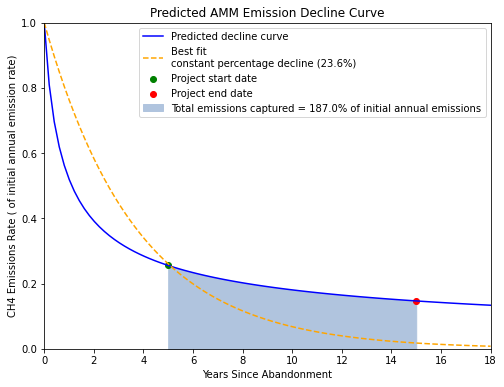

In [5]:
## Additional follow-up options: comparison to constant percentage drop, more to follow.

def ask2_1():
    next_steps = input("""If you want to compare your decline curve to a constant percentage drop,
    input 'compare'. """)
    if next_steps.lower() == 'compare':
        def percent_drop(x, b):
            y = q_i * ((1-b) ** x)
            return y
        fit, fit_cov = optimize.curve_fit(percent_drop, time, q_mid(time), p0=[.15])
        plt.plot(time, q_mid(time), color='blue', label='Predicted decline curve')
        plt.plot(time, percent_drop(time, fit), color='orange', linestyle='dashed', label="""Best fit 
constant percentage decline (%s%%)""" %str(round(fit[0]*100, 1)))
        plt.fill_between(project_interval, q_mid(project_interval), 0, color='lightsteelblue')
        plt.scatter(x=tsa, y=q_mid(tsa), color='g', label='Project start date')
        plt.scatter(x=tsa+pl, y=q_mid(tsa+pl), color='r', label='Project end date')
        plt.fill_between(project_interval,0, color='lightsteelblue', 
                 label='Total emissions captured = %s' % label_units)
        plt.xlim([0,years])
        plt.ylim([0,q_i])
        plt.xlabel("Years Since Abandonment")
        if units == ' of initial emission rate':
            plt.ylabel("CH4 Emissions Rate (fraction %s)" %units)
        else:
            plt.ylabel("CH4 Emissions Rate (%s)" %units)
            plt.legend()
            plt.title('Predicted AMM Emission Decline Curve')
            plt.rcParams["figure.figsize"] = (8, 6)
            plt.show()
            
ask2_1()